#  **Probability of a customer ceasing repayment of their balance**</font>

#### ⚡ <font face="Arial"> **Mauricio Toro, data scientist candidate** </font>

####  📅 <font face="Arial">  **September 16th 2024** </font>

## ⛳**1. Business Understanding**


## Project Overview

Develop a risk model to measure the probability of a customer ceasing repayment of their balance. Your task is to fit a classifier to predict which customers will be unable to pay their balance within the next 12 months, given some information at the time of the application.


## Output

### For this task

Attach:
- A `.ipynb` file (preferred) or a `.py` file (or a combination).
- Model file (e.g., in pickle format) and an inference script.
- Relevant visualizations of your analysis, either as part of the notebook or a separate file (e.g., PowerPoint). You might need to explain your approach and findings with the help of these visualizations in a follow-up session.



## Evaluation

You will be evaluated based on:
- Coding standards
- Chosen approach
- Model performance

If the features were not anonymized, what extra checks would you perform to further evaluate the validity of your model? Feel free to share thoughts on other approaches that might be useful and what additional data might enhance your current approach.

Model performance will be evaluated using the test set and a holdout set. The probability output will be used to decide if an application is accepted or rejected.



## Questions & Answers

#### 	1.	How do you plan to use the probability output? Are you thinking of offering a treatment to those with high probabilities of ceasing payments? What about those with low probabilities? Do you need a calibrated probability, or would a score be enough?

- While a score alone is sufficient, it is beneficial to explain the advantages of a well-calibrated probability and its potential uses.

####	2.	What infrastructure are you considering for deploying this model? Do you envision using a smaller CPU machine, or would it be worth deploying on a larger machine with a GPU for deep learning in case deep learning proves to be better than a traditional machine learning approach?


- Do not worry about infrastructure for now. Keep in mind that this is a high-materiality model, meaning it will have a financial impact on customers.


####	3.	Do you have an estimate of the costs associated with misclassifying someone as likely to cease paåyments versus not likely to cease payments?

- You do not need to make assumptions about the costs associated with a defaulted account. This is a unit-rate model. However, provide notes on how you would handle it if you had the loss associated with a defaulted account.

####    4.    Which business metric or KPI will be most impacted by this prediction?

- Document which KPIs are impacted by a model applied during a credit card application process and identify the most important KPI for a credit card company.


## ⛳**2. Exploratory Data Analysis**

### ◼ Install the Required Libraries


Recommended environment: Run this in Google Colab

In [ ]:
!pip install --quiet pandas scikit-optimize xgboost shap pywaffle graphviz

### ◼  Import Required Libraries


In [ ]:
import pandas as pd #This library is used for data understanding and preparation
import os #To handle paths in a way that is portable
from sklearn.metrics import confusion_matrix #Confusion matrix for model evaluation
from sklearn.metrics import classification_report, roc_curve, auc #For machine learning metrics
import xgboost as xgb #To train an xgboost classifier
import pickle #To save machine-learning models
from skopt import BayesSearchCV #For hyperparameter optimization
from skopt.space import Integer, Real #For the priories in hyperparameter optimization
import matplotlib.pyplot as plt #To make some plots
import numpy as np #To process some vectors
import shap #For explanability
from google.colab import drive #To load the datasets in Google Colab
from pywaffle import Waffle #This library is used for waffle plots
from graphviz import Digraph #To display the outline of the notebook
from IPython.display import Image #To display estimators of the XGBoost model

### ◼  Define Global Constants and Configurations


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Company's brand colours
dark_blue = "#05becd"
light_blue = "#1fe0df"
black = "black"
dark_gray = "#1d1d1f"
gray = "gray"
light_gray = "#d3d3d3"

#### ⚡ **Notebook Outline**

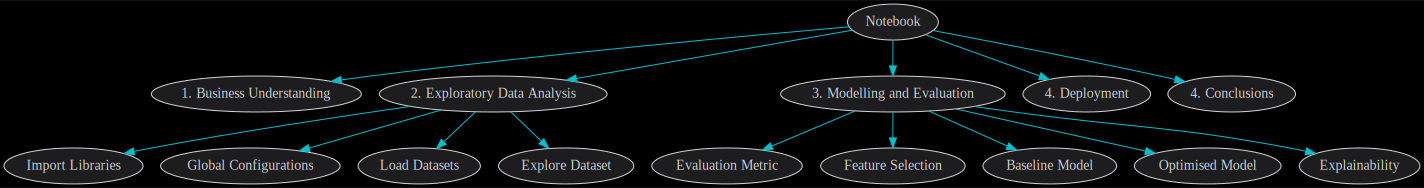

In [ ]:
# Initialize a new directed graph
dot = Digraph(comment='Structure of the document')

# Set graph attributes
dot.attr(bgcolor=black)  # Set background color to black

# Set default node and edge attributes
dot.attr('node', style='filled', fillcolor=dark_gray, fontcolor=light_gray, color=light_gray)  # Dark blue text, light blue outline
dot.attr('edge', color=dark_blue)  # Light blue arrows

# Define the tree structure
dot.node('A', 'Notebook')         # Root node
dot.node('B', '1. Business Understanding')          # First child of root
dot.node('C', '2. Exploratory Data Analysis')          # Second child of root
dot.node('D', '3. Modelling and Evaluation')          # Third child of root
dot.node('E', '4. Deployment')          # Fourth child of root
dot.node('F', '4. Conclusions')       # Fifth child of root

dot.node('C2', 'Import Libraries')     # Child of Son 1
dot.node('C3', 'Global Configurations')     # Child of Son 1
dot.node('C4', 'Load Datasets')     # Child of Son 1
dot.node('C5', 'Explore Dataset')     # Child of Son 1

dot.node('D1', 'Evaluation Metric')     # Child of Son 2
dot.node('D2', 'Feature Selection')     # Child of Son 2
dot.node('D3', 'Baseline Model')     # Child of Son 2
dot.node('D4', 'Optimised Model')     # Child of Son 2
dot.node('D5', 'Explainability')     # Child of Son 2


# Define edges between nodes to create hierarchy
dot.edge('A', 'B')              # Father -> Son
dot.edge('A', 'C')              # Father -> Son
dot.edge('A', 'D')              # Father -> Son
dot.edge('A', 'E')              # Father -> Son
dot.edge('A', 'F')              # Father -> Son

dot.edge('C', 'C2')              # Son -> Grandson
dot.edge('C', 'C3')              # Son -> Grandson
dot.edge('C', 'C4')              # Son -> Grandson
dot.edge('C', 'C5')              # Son -> Grandson

dot.edge('D', 'D1')              # Son -> Grandson
dot.edge('D', 'D2')              # Son -> Grandson
dot.edge('D', 'D3')              # Son -> Grandson
dot.edge('D', 'D4')              # Son -> Grandson
dot.edge('D', 'D5')              # Son -> Grandson

# Render and display the tree
display(dot)

#### ⚡ **Helper Functions**

In [ ]:
def plot_roc_curve(y_true,y_pred_prob,dataset):
  # Compute ROC curve and ROC area
  fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
  roc_auc = auc(fpr, tpr)

  # Plotting the ROC curve
  plt.figure(figsize=(10, 8))
  plt.plot(fpr, tpr, color=dark_blue, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color=gray, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) '+dataset.capitalize())
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

In [ ]:
def missing_values_summary(df):
    # Count total missing values for each column
    missing_count = df.isnull().sum()

    # Calculate percentage of missing values for each column
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Create a DataFrame summarizing the missing data
    missing_summary = pd.DataFrame({
        'Missing Values': missing_count,
        'Percentage': missing_percentage
    })

    # Filter only columns with missing data and sort by the most missing
    missing_summary = missing_summary[missing_summary['Percentage'] > 70]
    missing_summary = missing_summary.sort_values(by='Percentage', ascending=False)

    return missing_summary

### ◼  Load Training and Evaluation Datasets


In [ ]:
# Define the path to the folder in Google Drive
path = "/content/drive/My Drive/Colab Notebooks/Finance_Coding_Challenge/"

# Define the list of dataset names
datasets = ["X_train.csv", "X_test.csv", "y_train.csv", "y_test.csv"]

# Create a dictionary with the dataset names as keys and the DataFrames as values
data_dict = {dataset_name.split('.')[0]: pd.read_csv(os.path.join(path, dataset_name)) for dataset_name in datasets}

### ◼  Briefly Explore the Training Dataset



In [ ]:
data_dict['X_train'].head()

,account_id,score_1,balance_1,balance_2,balance_3,utilization_1,utilization_2,utilization_3,balance_4,recency_1,...,utilization_15,utilization_16,repayment_history_30,balance_24,repayment_history_31,spend_behaviour_5,utilization_17,utilization_18,financial_situation_4,financial_situation_5
0,8123600,825.348911,11.980223,10412.320555,21.988282,7.690251,22.023130,NaN,3154.786103,226.394048,...,0.002270,11.963410,2482.620405,NaN,-0.009168,NaN,0.000895,0.205631,P1,B
1,8107557,542.357621,6.081661,222.994664,3.955737,96.695360,96.468042,4.140717,207.996862,10.552500,...,2.005005,2.047720,367.742915,NaN,0.005128,NaN,-0.002077,96.198908,S1,E
2,8127625,866.412241,10.976061,11848.730876,13.964518,27.601344,31.966556,NaN,7349.501613,64.600528,...,-0.022786,7.049938,5851.570408,NaN,0.004679,NaN,-0.003735,31.321457,S1,E
3,8123537,1064.233177,9.945194,19807.572456,0.966109,2.183612,1.082774,NaN,77064.365076,414.524439,...,0.022199,11.966209,6792.549797,NaN,0.011051,1.002681,-0.004331,0.328296,P1,B
4,8091675,638.246169,4.994729,1199.463656,NaN,NaN,NaN,NaN,210.087106,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S2,G


#### ✅ **Recommendation: The variables in the dataset exhibit different scales. If you plan to use a model in the future that is sensitive to feature scaling, consider standardizing the values to ensure consistent model performance.**



#### ⚡ **Missing Values**

In [ ]:
print(missing_values_summary(data_dict['X_train']))

                       Missing Values  Percentage
repayment_history_25            26872   94.629714
recency_9                       26872   94.629714
balance_7                       26712   94.066275
utilization_12                  26668   93.911329
balance_24                      25872   91.108216
recency_10                      25768   90.741980
financial_situation_2           24994   88.016340
balance_13                      24894   87.664190
spend_behaviour_3               24191   85.188576
utilization_3                   24046   84.677959
utilization_5                   24020   84.586400
balance_22                      23947   84.329331
spend_behaviour_1               23875   84.075783
repayment_history_28            23745   83.617988
repayment_history_21            23707   83.484171
balance_15                      23498   82.748178
repayment_history_18            23171   81.596648
spend_behaviour_5               22995   80.976864
utilization_10                  22973   80.899391


In [ ]:
missing_values_columns = missing_values_summary(data_dict['X_train']).index
missing_values_columns

Index(['repayment_history_25', 'recency_9', 'balance_7', 'utilization_12',
       'balance_24', 'recency_10', 'financial_situation_2', 'balance_13',
       'spend_behaviour_3', 'utilization_3', 'utilization_5', 'balance_22',
       'spend_behaviour_1', 'repayment_history_28', 'repayment_history_21',
       'balance_15', 'repayment_history_18', 'spend_behaviour_5',
       'utilization_10', 'balance_17'],
      dtype='object')

#### ✅ **Recommendation: Some variables in the dataset have a significant amount of missing data, with percentages exceeding 70%. If we select model in a future iteration does not effectively handle missing values, remove these variables or impute the missing values. However, consider that features may contain `NaN` values indicating the absence of information or an event. For example, `recency_1` measures how many months have passed since an event in the applicant’s repayment history; if the event never took place, the value will be `NaN`.**


#### ⚡ **Non numerical features**

In [ ]:
# Identify non-numeric columns
non_numeric_cols = data_dict['X_train'].select_dtypes(exclude='number').columns
print("Non-numeric columns:")
print(non_numeric_cols)

Non-numeric columns:
Index(['financial_situation_4', 'financial_situation_5'], dtype='object')


#### ✅ **Recommendation: For most models, non-numeric columns should be encoded into numerical formats, such as through one-hot encoding.**

#### ⚡ **Correlation Analysis**

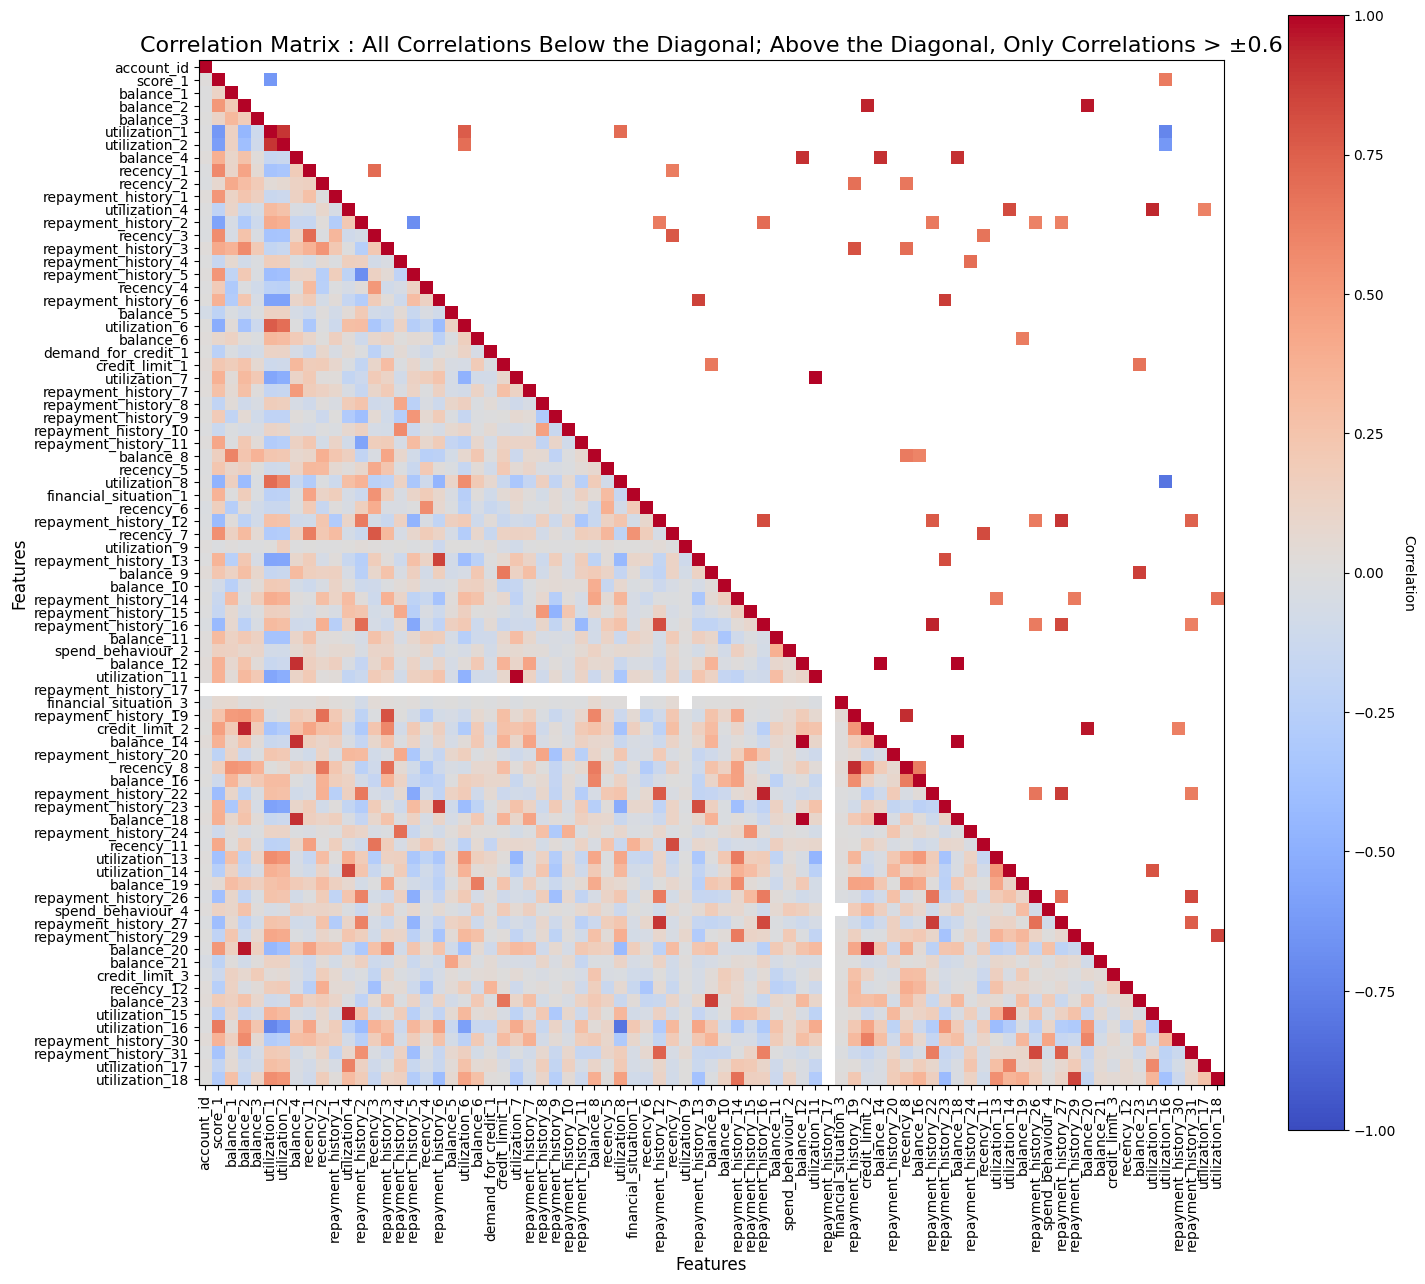

In [ ]:
# Filter out non-numeric columns
numeric_df = data_dict['X_train'].select_dtypes(include='number')

# Filter out columns with missing values
filtered_numeric_df = numeric_df.drop(columns=missing_values_columns)

# Calculate the correlation matrix
corr = filtered_numeric_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Mask correlations below the threshold
mask_lower = np.abs(corr) < 0.6
mask = mask & mask_lower

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust size to make sure all features fit

# Plot the heatmap using imshow with the mask
cax = ax.imshow(corr, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
cax.set_visible(False)

# Add color bar
cbar = fig.colorbar(cax, ax=ax, shrink=0.8)
cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom")

# Set axis labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

# Add labels for x and y axes
plt.xlabel('Features', size=12)
plt.ylabel('Features', size=12)
plt.title('Correlation Matrix : All Correlations Below the Diagonal; Above the Diagonal, Only Correlations > ±0.6', size=16)

# Apply the mask to the correlation matrix
masked_corr = np.ma.masked_where(mask, corr)

# Plot the masked heatmap
cax = ax.imshow(masked_corr, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)

# Add gridlines
ax.grid(False)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Find columns with a correlation higher than 0.9
high_corr_columns = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            colname = corr.columns[i]
            high_corr_columns.add(colname)
            high_corr_columns.add(corr.columns[j])

# Convert to list
high_corr_columns = list(high_corr_columns)

high_corr_columns

['balance_12',
 'utilization_7',
 'balance_20',
 'balance_4',
 'utilization_15',
 'utilization_11',
 'utilization_4',
 'repayment_history_22',
 'balance_14',
 'repayment_history_19',
 'recency_8',
 'repayment_history_16',
 'balance_18',
 'balance_2',
 'credit_limit_2']

#### ✅ **Recommendation: Some variables exhibit high correlation with each other. If a future iteration of the model is sensitive to multicollinearity, consider removing highly correlated variables.**

In [ ]:
# Total number of columns in the original dataframe
total_columns = len(data_dict['X_train'].columns)

# Number of columns removed
num_missing = len(missing_values_columns)
num_non_numeric = len(non_numeric_cols)
num_high_corr = len(high_corr_columns)

# Number of remaining columns
remaining_columns = total_columns - (num_missing + num_non_numeric + num_high_corr)

# Calculate percentages
percent_missing = (num_missing / total_columns) * 100
percent_non_numeric = (num_non_numeric / total_columns) * 100
percent_high_corr = (num_high_corr / total_columns) * 100
percent_remaining = (remaining_columns / total_columns) * 100

# Print results
print(f"Total columns: {total_columns}")
print(f"Number of columns with high percentage of missing values: {num_missing} ({percent_missing:.2f}%)")
print(f"Number of non-numeric columns: {num_non_numeric} ({percent_non_numeric:.2f}%)")
print(f"Number of highly correlated columns: {num_high_corr} ({percent_high_corr:.2f}%)")
print(f"Number of remaining columns: {remaining_columns} ({percent_remaining:.2f}%)")

Total columns: 101
Number of columns with high percentage of missing values: 20 (19.80%)
Number of non-numeric columns: 2 (1.98%)
Number of highly correlated columns: 15 (14.85%)
Number of remaining columns: 64 (63.37%)


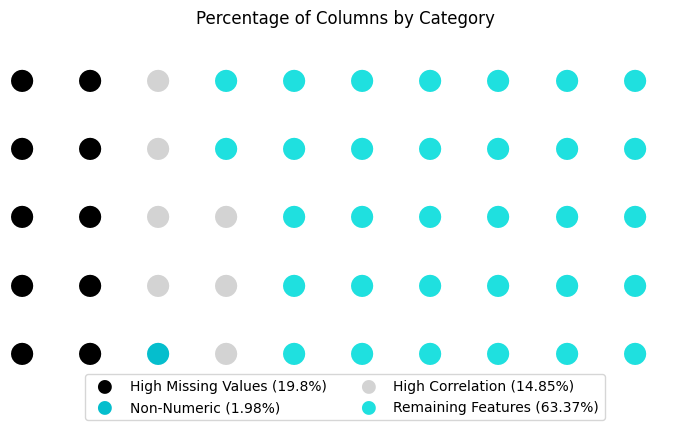

In [ ]:
# Data for waffle chart
data = {
    'High Missing Values': percent_missing,
    'Non-Numeric': percent_non_numeric,
    'High Correlation': percent_high_corr,
    'Remaining Features': percent_remaining
}

# Prepare data for waffle chart
percents_of_groups_of_categories = pd.Series(data)

# Colors for each group
colors = [  black,  dark_blue, light_gray, light_blue]

# Create waffle chart
plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=percents_of_groups_of_categories,
    colors=colors,
    title={'label': 'Percentage of Columns by Category'},
    labels=[f"{k} ({round(v,2)}%)" for k, v in percents_of_groups_of_categories.items()],
    legend={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.2), 'ncol': 2, 'fancybox': True},
    icon_legend=True,
    icon_size=16,
    icons='circle'
)

# Adjust the figure size if needed
plt.gcf().set_size_inches(7, 5)  # Increase width and height for more space
plt.show()

## ⛳**3. Modelling and Evaluation**

### **◼ Define Evaluation Metric** ###

⚡ Metric Selection

AUC:

	1.	Evaluates model performance across all classification thresholds.
	2.	Provides a robust measure unaffected by class imbalance.
	3.	Assesses the model’s ability to rank positive instances higher than negative ones.

F1 Score:

	1.	Balances precision and recall, useful for managing trade-offs between accurate positive predictions and identifying all positives.
	2.	Provides a comprehensive view of model performance when the costs of false positives and negatives are equal.

#### ✅ **Recommendation: Although this is the case of a unit-rate model, false positives and false negatives likely have different costs, so I recommend using AUC as the metric for this model. AUC is well-suited for ranking individuals by their probability of ceasing repayment, which allows for targeted interventions at different probability thresholds to reduce default rates.**



### **◼ Feature Selection** ###

In [ ]:
for features_string, labels_string in [('X_train','y_train'),('X_test','y_test')]:
    features = data_dict[features_string]
    labels = data_dict[labels_string]

    # Verify that both DataFrames have the same account_ids
    if not features['account_id'].equals(labels['account_id']):
        raise ValueError("The account_id values in DataFrames 'a' and 'b' do not match.")

    # Sort both DataFrames by account_id
    features.sort_values(by='account_id', inplace=True)
    labels.sort_values(by='account_id', inplace=True)

    # Reset the index to ensure both DataFrames are aligned after sorting
    features.reset_index(drop=True, inplace=True)
    labels.reset_index(drop=True, inplace=True)

    # Drop the account_id column from both DataFrames in place
    features.drop(columns=['account_id'], inplace=True)
    labels.drop(columns=['account_id'], inplace=True)

In [ ]:
for dataset in ['X_train','X_test']:
    # Convert 'financial_situation_4' and 'financial_situation_5' to one-hot encoding
    data_dict[dataset] = pd.get_dummies(data_dict[dataset], columns=non_numeric_cols , drop_first=False, dtype=int)

    # Remove the score obtained from a pre trained model from the features
    data_dict[dataset].drop(columns=['score_1'], inplace=True)

    # Remove variables that have a correlation higher than 0.9 with another variable
    data_dict[dataset].drop(columns=high_corr_columns , inplace=True)

#### ✅ **Recommendation: Avoid using the output of another machine learning model as a feature. This approach can create maintenance challenges, especially if the original model starts to drift or has data leakage issues. Such problems may necessitate retraining both the original model and the dependent model, potentially leading to a cascade effect.**

#### ✅ **Recommendation: Although XGBoost can handle highly correlated variables, relying on them may lead to inaccurate feature importance and SHAP value estimations, as the model might treat them interchangeably in tree splits.**



#### ✅ **Recommendation: To simplify future iterations, incorporate these transformations into a Scikit-Learn pipeline.**


### **◼ Baseline model** ###

#### ⚡ **An XGBoost with hyperparameters defined from prior experience**

In [ ]:
# Define the classifier with adhoc parameters for handling imbalance and regularization
xgb_model = xgb.XGBClassifier(
    n_jobs=-1,                             # Use all available CPUs
    scale_pos_weight=10,                   # Adjust based on the ratio of negative to positive samples
    alpha=10,                             # L1 regularization
    reg_lambda=10,                         # L2 regularisation
    gamma = 15                             # Less splits
)
xgb_model.fit(data_dict['X_train'].select_dtypes(include='number'), data_dict['y_train'].label.values.ravel())

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=15, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

#### ⚡ **Evaluation Metrics on Training Dataset**




In [ ]:
y_pred = xgb_model.predict(data_dict['X_train'].select_dtypes(include='number'))
y_pred_prob = xgb_model.predict_proba(data_dict['X_train'].select_dtypes(include='number'))[:, 1]  # Probabilities for the positive class
y_true = data_dict['y_train'].label.values.ravel()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     26754
           1       0.29      0.92      0.44      1643

    accuracy                           0.86     28397
   macro avg       0.64      0.89      0.68     28397
weighted avg       0.95      0.86      0.89     28397



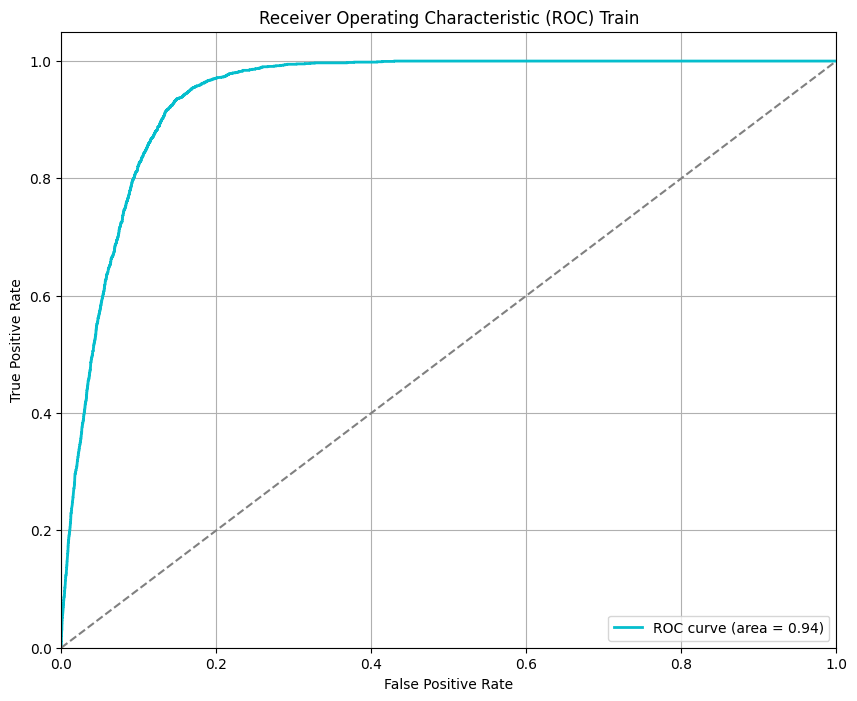

In [ ]:
plot_roc_curve(y_true,y_pred_prob,"train")

#### ⚡ **Evaluation Metrics on Evaluation Dataset**

In [ ]:
y_pred_test = xgb_model.predict(data_dict['X_test'].select_dtypes(include='number'))
y_pred_prob_test = xgb_model.predict_proba(data_dict['X_test'].select_dtypes(include='number'))[:, 1]  # Probabilities for the positive class
y_true_test = data_dict['y_test'].label.values.ravel()

In [ ]:
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7907
           1       0.20      0.65      0.31       485

    accuracy                           0.83      8392
   macro avg       0.59      0.75      0.61      8392
weighted avg       0.93      0.83      0.87      8392



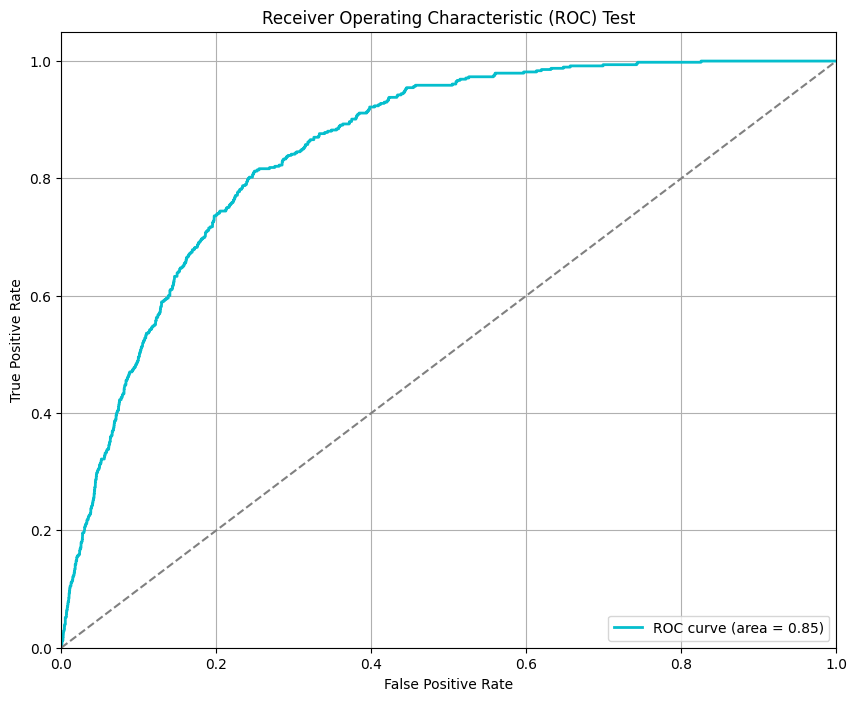

In [ ]:
plot_roc_curve(y_true_test,y_pred_prob_test,"test")

#### ✅ **Recommendation: The model exhibits some overfitting, as it performs  better on the training dataset compared to the validation dataset. Additionally, while the model predicts class 0 well, it struggles with class 1. In the next iteration, address overfitting and class imbalance issues.**


### **◼ An XGBoost with better parameters** ###

In [ ]:
# Define the search space
search_space = {
    'n_estimators': Integer(50, 800),
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),
    'max_depth': Integer(2, 4),
    'scale_pos_weight': Integer(0,50),
    'alpha': Real(0.01, 10, prior='log-uniform'),
    'reg_lambda': Real(0.01, 10, prior='log-uniform'),
    'gamma': Real(0.01, 10, prior='log-uniform')
}

# Define the model
xgb_model = xgb.XGBClassifier(
    n_jobs=-1
)

# Perform Bayesian Optimization
opt = BayesSearchCV(
    xgb_model,
    search_space,
    n_iter=5,  # Number of iterations
    scoring='roc_auc',
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,
    verbose=1
)

# Fit the model
opt.fit(data_dict['X_train'], data_dict['y_train'].label.values.ravel())

# Extract the best estimator from the BayesSearchCV object
best_model = opt.best_estimator_

# Best parameters
print("Best parameters found: ", opt.best_params_)
print("Best ROC AUC score: ", opt.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:  OrderedDict([('alpha', 0.037448626361398785), ('gamma', 0.04165521697512574), ('learning_rate', 0.07183647111516682), ('max_depth', 2), ('n_estimators', 122), ('reg_lambda', 0.09798938204107523), ('scale_pos_weight', 10)])
Best ROC AUC score:  0.8455309698229467


#### ⚡ **Evaluation Metrics on both datasets**

X_train
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     26754
           1       0.19      0.77      0.31      1643

    accuracy                           0.80     28397
   macro avg       0.59      0.79      0.60     28397
weighted avg       0.94      0.80      0.85     28397

Confusion Matrix:
[[21532  5222]
 [  385  1258]]


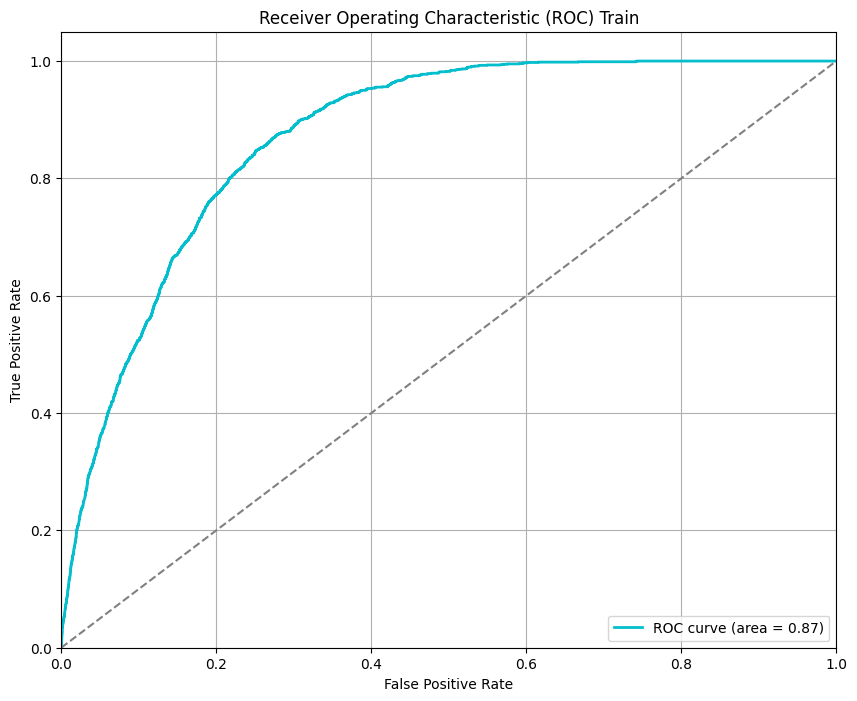

X_test
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      7907
           1       0.19      0.74      0.30       485

    accuracy                           0.80      8392
   macro avg       0.58      0.77      0.59      8392
weighted avg       0.93      0.80      0.85      8392

Confusion Matrix:
[[6330 1577]
 [ 127  358]]


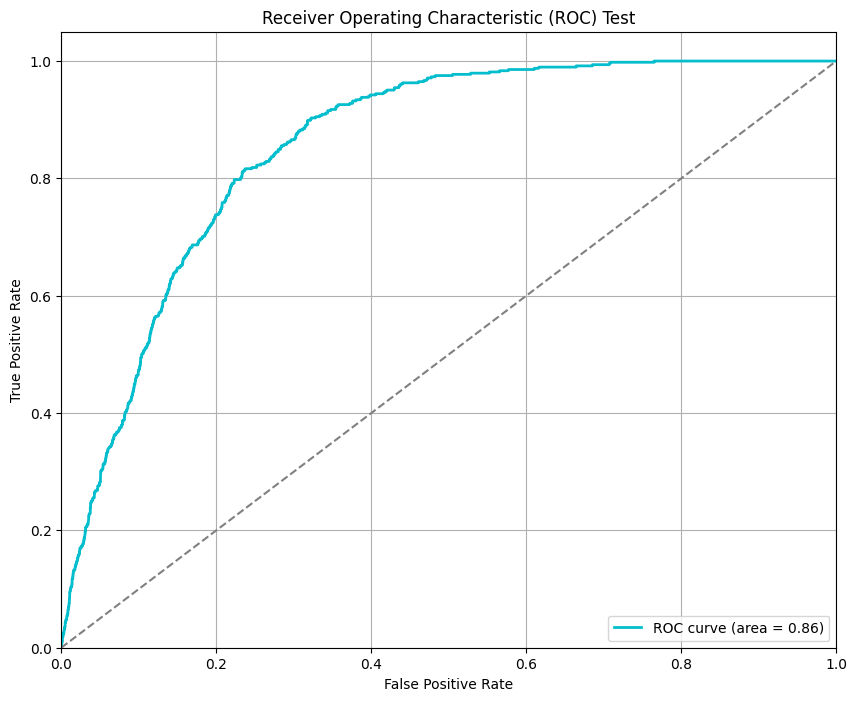

In [ ]:
evaluation_confusion_matrix = None
for features_string, labels_string in [('X_train','y_train'),('X_test','y_test')]:
    features = data_dict[features_string]
    labels = data_dict[labels_string]
    y_pred = best_model.predict(features)
    y_pred_prob = best_model.predict_proba(features)[:, 1]  # Probabilities for the positive class
    y_true = labels.label.values.ravel()
    print(features_string)
    print(classification_report(y_true, y_pred))

    # Compute and print confusion matrix using numpy
    conf_matrix = np.zeros((2, 2), dtype=int)  # Initialize 2x2 matrix for binary classification
    for true, pred in zip(y_true, y_pred):
        conf_matrix[true, pred] += 1
    if "test" in features_string:
      evaluation_confusion_matrix = conf_matrix

    print("Confusion Matrix:")
    print(conf_matrix)

    plot_roc_curve(y_true,y_pred_prob,features_string.split("_")[1] )

#### ✅ **Recommendation: The model is no longer overfitted, as indicated by the closer AUC values. However, the model still performs significantly better for class 0 compared to class 1. Before proceeding with further iterations, it is important to consult with business leaders to clarify their expectations for model performance and determine the acceptable trade-offs between precision and recall for each class.**

#### ⚡ **Business Metrics of the Model over the Evaluation Dataset**

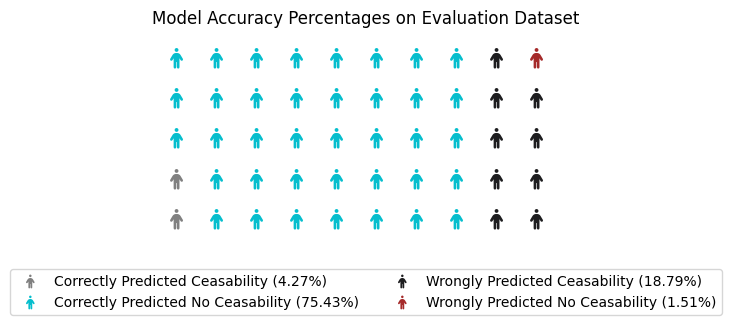

In [ ]:
# Extract values
TN, FP, FN, TP = evaluation_confusion_matrix.ravel()

# Calculate total number of cases
total_cases = TN + FP + FN + TP

# Calculate percentages
percent_correctly_predicted_ceasability = (TP / total_cases) * 100
percent_correctly_predicted_no_ceasability = (TN / total_cases ) * 100
percent_wrongly_predicted_ceasability = (FP / total_cases)  * 100
percent_wrongly_predicted_no_ceasability = (FN / total_cases ) * 100

# Prepare data for waffle plot
data = {
    'Correctly Predicted Ceasability': percent_correctly_predicted_ceasability,
    'Correctly Predicted No Ceasability': percent_correctly_predicted_no_ceasability,
    'Wrongly Predicted Ceasability': percent_wrongly_predicted_ceasability,
    'Wrongly Predicted No Ceasability': percent_wrongly_predicted_no_ceasability
}

# Convert to Series
percents_of_groups_of_categories = pd.Series(data)

# Define colors
colors = [gray, dark_blue, dark_gray, 'brown']

# Create waffle chart
plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=percents_of_groups_of_categories,
    colors=colors,
    title={'label': 'Model Accuracy Percentages on Evaluation Dataset'},
    labels=[f"{k} ({round(v,2)}%)" for k, v in percents_of_groups_of_categories.items()],
    legend={'loc': 'lower center', 'bbox_to_anchor': (0.5, -0.5), 'ncol': 2, 'fancybox': True},
    icon_legend=True,
    icon_size=15,
    icons='person'
)

plt.show()


### **◼  Explainability of the features that impact the most the ceasing repayment over the Testing Dataset** ###

#### ⚡ **Average Impact of Top 10 Model Features on the Probability of Ceasing Repayment**



In [ ]:
# Create the SHAP explainer
explainer = shap.Explainer(best_model, data_dict['X_test'])

# Compute SHAP values
shap_values = explainer(data_dict['X_test'])

 91%|==================  | 7673/8392 [00:12<00:01]       

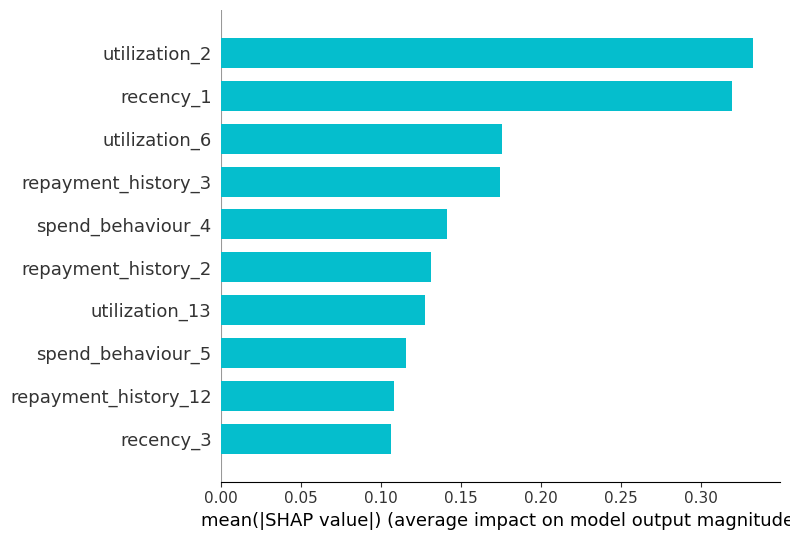

In [ ]:
# Plot SHAP bar plot for global feature importance
shap.summary_plot(shap_values, data_dict['X_test'], plot_type="bar", max_display=10, color = dark_blue)

# Show the plot
plt.show()

#### ⚡ **Individual Impact of Top 10 Model Features on the Probability of Ceasing Repayment**

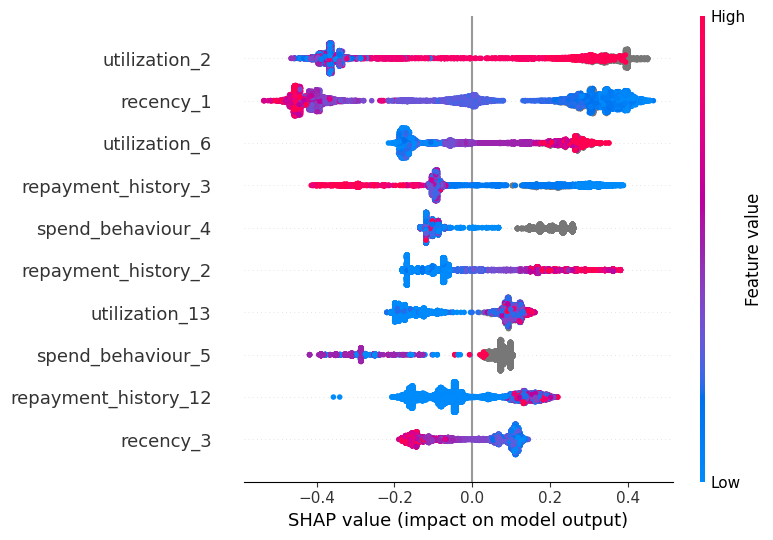

In [ ]:
# Plot SHAP summary plot showing the impact of each feature
shap.summary_plot(shap_values, data_dict['X_test'], max_display=10)

# Show the plot
plt.show()

#### ⚡ **First 3 Tree Estimators of the Best Model**

Tree_1


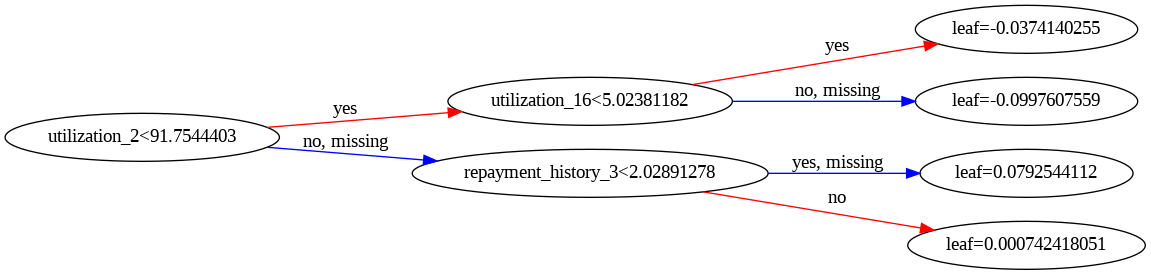

Tree_2


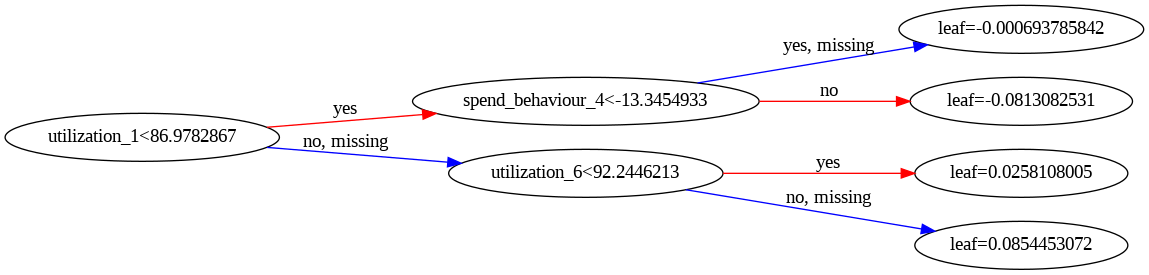

Tree_3


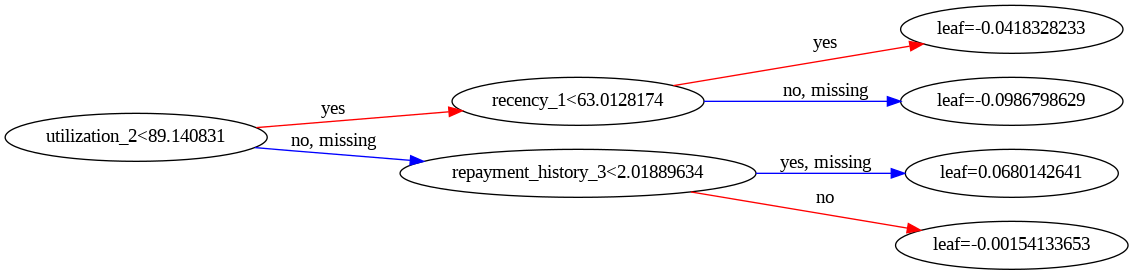

In [ ]:
def plot_tree_with_graphviz(model, num_trees):
    dot = xgb.to_graphviz(model, num_trees=num_trees, rankdir='LR')
    return dot

# Plot the first 3 trees with Graphviz
for i in range(3):
    dot = plot_tree_with_graphviz(best_model, i)
    dot.render(filename=f"tree_{i+1}", format='png', cleanup=True)

    # Display the tree using IPython display
    print(f"Tree_{i+1}")
    display(Image(filename=f"tree_{i+1}.png"))

    # To do:  Convert Log of Odds to Probability. Round split points to 1 or 0 decimals.

#### ✅ **Recommendation: While the features are anonymized, we can still infer the variables influencing the predictions. In this case, most important variable are those related to repayment history, utilisation and recency. It is crucial to validate these variables with business leaders.**

#### ✅ **Recommendation: Presenting the first 3 trees from the XGBoost model can help business leaders gain insights into the model’s decision-making process. This approach provides a clearer understanding of how the model operates, fostering transparency and building trust by demonstrating that it is not just a “black box,” but a system with some interpretable logic.**

## ⛳**4. Deployment**

In [ ]:
with open(os.path.join(path, 'xgboost.pickle'), 'wb') as handle:
    pickle.dump(best_model, handle)

In [ ]:
import pandas as pd
import pickle
import os

# Define the path where the model and test data are located
path = "/content/drive/My Drive/Colab Notebooks/Finance_Coding_Challenge/"

# Load the saved XGBoost model from the pickle file
with open(os.path.join(path, 'xgboost.pickle'), 'rb') as handle:
    model = pickle.load(handle)

# Load the X_test data
X_test = pd.read_csv(os.path.join(path, 'X_test.csv'))

# Convert 'financial_situation_4' and 'financial_situation_5' to one-hot encoding
X_test = pd.get_dummies(X_test , columns=['financial_situation_4', 'financial_situation_5'], drop_first=False, dtype=int)

# Remove the score obtained from a pre trained model and the account id from the features
X_test.drop(columns=['score_1','account_id'], inplace=True)

# Remove highly correlated features
X_test.drop(columns=['balance_12', 'utilization_7', 'balance_20', 'balance_4', 'utilization_15', 'utilization_11', 'utilization_4', 'repayment_history_22', 'balance_14', 'repayment_history_19', 'recency_8', 'repayment_history_16', 'balance_18', 'balance_2', 'credit_limit_2'],inplace=True)

# Make predictions
predictions = model.predict(X_test)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['predicted_label'])

# Print the DataFrame
print(predictions_df)

      predicted_label
0                   0
1                   0
2                   0
3                   0
4                   0
...               ...
8387                0
8388                0
8389                1
8390                1
8391                0

[8392 rows x 1 columns]


#### ⚡ **Create a Python Inference Script**

In [ ]:
# Define the content of the inference script
inference_script = """
import pandas as pd
import pickle
import os

# Define the path where the model and test data are located
path = "./Finance_Coding_Challenge/"

# Load the saved XGBoost model from the pickle file
with open(os.path.join(path, 'xgboost.pickle'), 'rb') as handle:
    model = pickle.load(handle)

# Load the X_test data
X_test = pd.read_csv(os.path.join(path, 'X_test.csv'))

# Convert 'financial_situation_4' and 'financial_situation_5' to one-hot encoding
X_test = pd.get_dummies(X_test , columns=['financial_situation_4', 'financial_situation_5'], drop_first=False, dtype=int)

# Remove the score obtained from a pre trained model and the account id from the features
X_test.drop(columns=['score_1','account_id'], inplace=True)

# Remove highly correlated features
X_test.drop(columns=['balance_12', 'utilization_7', 'balance_20', 'balance_4', 'utilization_15', 'utilization_11', 'utilization_4', 'repayment_history_22', 'balance_14', 'repayment_history_19', 'recency_8', 'repayment_history_16', 'balance_18', 'balance_2', 'credit_limit_2'],inplace=True)

# Make predictions
predictions = model.predict(X_test)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['predicted_label'])

# Print the DataFrame
print(predictions_df)
"""

# Write the content to 'inference.py'
with open(os.path.join(path, 'inference.py'), 'w') as file:
    file.write(inference_script)

print("inference.py has been created.")

inference.py has been created.


## ⛳**5. Conclusions**

⚡ Business implications of the current model performance

Pros:

	1.	High Recall for Class 1: Useful in identifying most of the customers who will default. This helps in taking preventative actions, such as adjusting credit limits or sending reminders to potentially risky customers.
	2.	High Precision for Class 0: Ensures that most customers who are predicted as non-defaults indeed do not default. This is beneficial for maintaining good customer relations and ensuring smooth operations.

 Cons:

	1.	Low Precision for Class 1: With very low precision, there is a high rate of false positives. This means a lot of customers are incorrectly flagged as likely to default, which can lead to unnecessary actions (e.g., denying credit or initiating collection efforts). This could harm customer relationships and result in lost revenue from good customers who are incorrectly classified.
	2.	Operational Impact: The low precision for defaults might result in inefficient use of resources, such as spending time and money on customers who are unlikely to default.

⚡  This model has potential to enhance the company’s default rate management. Before moving forward with additional experiments, it’s essential to validate the model’s current performance and align it with the business team’s expectations. Additionally, present the key variables affecting the ceasing repayment probability to the business team and gather their feedback.

⚡ To enhance model performance, explore class imbalance techniques such as oversampling (e.g., SMOTE), undersampling, or a combination of both. Evaluate their impact on the model and select the most effective approach. If SMOTE is used, ensure to handle missing values appropriately.

⚡  The model currently outputs a propensity score rather than a calibrated probability. For future iterations, consider using well-calibrated probabilities. Calibrated probabilities allow for adjustable thresholds based on the company’s loss given default and offer greater transparency, which facilitates easier justification to regulators.

⚡ **If the features were not anonymized, I would perform the following checks:**

1. Ensure that the features do not drift over time.
2. Verify that the features do not present any data leakage.
3. Determine whether the missing values signify an absence of action or if they are random, possibly due to issues with data pipelines.
4. Identify the features that were used to train the pre-trained model.